In [1]:
# To do:
# Fix Dates, must be another published on vs premiered on discrepancy -- OK
# Fix Titles -- OK
# Looks like missing one (1) video for Gibi 344/345 -- OK
# DUPLICATES -- OK
# EDGE CASES ▶ -- OK
# User entered date range --
# Better commenting --
# Duration --

# Import Dependencies
from bs4 import BeautifulSoup as bs
import requests
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import time
pd.set_option('display.max_rows', 500)

In [2]:
converted_date = ""
raw_months = {"Jan": 1, "Feb": 2, "Mar" : 3, "Apr" : 4, 
              "May" : 5, "Jun" : 6, "Jul" : 7, "Aug" : 8,
              "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12}

# Convert Date from Jan 1, 1999 format to datetime object
def convertDate(raw_date):
    
    converted_date = ""
    
    number_month = raw_months.get(raw_date[0])
    
    date_str = (str(number_month) + "/" + raw_date[1] + "/" + raw_date[2]).replace(",", "")
    
    converted_date = datetime.strptime(date_str, '%m/%d/%Y')
    
    return converted_date

In [3]:
# Get Youtuber's Name
input_name = input("Enter Youtuber's Name: ")

list_name = input_name.split()

converted_name = input_name

if len(list_name) > 1:
    
    converted_name = ""
    
    for i in range(len(list_name)):

        converted_name = converted_name + list_name[i]
        
        if i != len(list_name)-1:
            converted_name = converted_name + "+"

search_name = converted_name

start_url = "https://www.youtube.com/results?search_query=" + search_name

Enter Youtuber's Name: jojo's asmr


In [4]:
print(start_url)
get_youtube_url_response = requests.get(start_url)

https://www.youtube.com/results?search_query=jojo's+asmr


In [5]:
youtube_name_soup = bs(get_youtube_url_response.text, "lxml")

In [6]:
raw_youtube_name_link = youtube_name_soup.find_all("div", class_="yt-lockup-byline")[0].a.get("href")

videos_link = "https://www.youtube.com" + raw_youtube_name_link + "/videos"

about_link = "https://www.youtube.com" + raw_youtube_name_link + "/about"

print(videos_link)
print(about_link)

https://www.youtube.com/channel/UCjyi6by44TTH0j_U3vXEGpA/videos
https://www.youtube.com/channel/UCjyi6by44TTH0j_U3vXEGpA/about


In [7]:
# Get About Information
about_html = requests.get(about_link)

# Parse HTML
about_soup = bs(about_html.text, "lxml")

In [8]:
# Artist Information
artist_name = about_soup.find("meta", property="og:title").get("content")

subscribers = about_soup.find_all("span", class_="about-stat")[0].text
subscribers_int = int(subscribers.split(" ")[0].replace(",",""))

total_views = about_soup.find_all("span", class_="about-stat")[1].text
total_views_int = int(total_views[3:len(total_views)].split(" ")[0].replace(",",""))

joined = about_soup.find_all("span", class_="about-stat")[2].text
joined_temp = joined.split(" ")[1:4]
joined_convert = convertDate(joined_temp)

print(f"Artist: {artist_name}")
print(f"Subscribers: {subscribers_int}")
print(f"Views: {total_views_int}")
print(f"Joined: {joined_convert}")

Artist: Jojo's ASMR
Subscribers: 506556
Views: 108867866
Joined: 2015-01-19 00:00:00


In [9]:
# Convert User Name to UU Format
youtube_code = raw_youtube_name_link.split("/")[2]

if youtube_code[0:2] == "UC":
    
    youtube_code = raw_youtube_name_link.split("/")[2]

    playlist_link = "https://www.youtube.com" + "/playlist?list=UU" + youtube_code[2:] 

elif youtube_code[0:2] != "UC":
    
    youtube_code_raw = about_soup.find("link", rel="canonical").get("href")
    
    youtube_code = youtube_code_raw.split("/")[4]
    
    playlist_link = "https://www.youtube.com" + "/playlist?list=UU" + youtube_code[2:]  
    

print(playlist_link)

https://www.youtube.com/playlist?list=UUjyi6by44TTH0j_U3vXEGpA


In [10]:
# Get Playlist Response
playlist_response = requests.get(playlist_link)

In [11]:
# Create Playlist Soup Object
playlist_soup = bs(playlist_response.text, 'lxml')

In [12]:
# Get First Video URL as Starting Point
first_video = "https://www.youtube.com" + playlist_soup.find_all("a", class_="pl-video-title-link")[0].get("href").split("&")[0]
first_video_within_playlist = first_video + "&" + playlist_link.split("?")[1]

print(first_video_within_playlist)

https://www.youtube.com/watch?v=8ALn2hsekBc&list=UUjyi6by44TTH0j_U3vXEGpA


In [13]:
# Create Soup Object for First Video Inside Playlist
playlist_inside_request = requests.get(first_video_within_playlist) 

playlist_inside_soup = bs(playlist_inside_request.text, "lxml")

In [14]:
urls_all = []
total_videos_in_playlist = int(playlist_inside_soup.find("span", id="playlist-length").text.replace(" videos","").replace(",",""))
number_of_videos_in_page = len(playlist_inside_soup.find_all("span", class_="index")) 
last_video_index = int(playlist_inside_soup.find_all("span", class_="index")[-1].text.replace("\n        ","").replace("\n    ",""))
last_shown_link = playlist_inside_soup.find_all("span", class_="index")[-1].find_next("a").get("href")
link_fix = "https://www.youtube.com" + last_shown_link
    
for i in range(total_videos_in_playlist):   

    if i == 0:
        
#        print(f"loop1, i={i}")
        
        first_link = playlist_inside_soup.find("span", class_="index", text=f"\n        ▶\n    ")
        
        url = "https://www.youtube.com" + first_link.find_next("a").get("href")
        
        original_url = url.split("&")[0]

        urls_all.append(original_url)
        
        next_link = first_link
        
    elif i == last_video_index:

#        print(f"loop2, i={i}------------------------------------------------")
        
        playlist_inside_request = requests.get(link_fix)
        
        playlist_inside_soup = bs(playlist_inside_request.text, "lxml")
        
        last_shown_link = playlist_inside_soup.find_all("span", class_="index")[-1].find_next("a").get("href")
        
        link_fix = "https://www.youtube.com" + last_shown_link
        
        last_video_index = int(playlist_inside_soup.find_all("span", class_="index")[-1].text.replace("\n        ","").replace("\n    ",""))
        
        first_link = playlist_inside_soup.find("span", class_="index", text=f"\n        {i+1}\n    ")

        if first_link is None:
            
            next_link = playlist_inside_soup.find("span", class_="index", text=f"\n        ▶\n    ")
            
        else:
            
            next_link = first_link
        
        next_url = "https://www.youtube.com" + next_link.find_next("a").get("href")
        
        original_url = next_url.split("&")[0]
        
        urls_all.append(original_url)
        
        number_of_videos_in_page = len(playlist_inside_soup.find_all("span", class_="index")) - 1
              
    else:
        
#        print(f"loop3, i={i}")
 
        if i == 1:

            first_link = playlist_inside_soup.find("span", class_="index", text=f"\n        ▶\n    ")
            
        elif playlist_inside_soup.find("span", class_="index", text=f"\n        {i}\n    ") is None:
            
            first_link = playlist_inside_soup.find("span", class_="index", text=f"\n        ▶\n    ")
        
        else:
        
            first_link = playlist_inside_soup.find("span", class_="index", text=f"\n        {i}\n    ")
            
#         print(f"{first_link}")

        next_link = first_link
        
#         print(f"{next_link}")

        next_link = next_link.find_next("span", class_="index")

        next_url = "https://www.youtube.com" + next_link.find_next("a").get("href")

        original_url = next_url.split("&")[0]

        urls_all.append(original_url)
        
    print(f"({i+1}/{total_videos_in_playlist})")


loop1, i=0
loop3, i=1
loop3, i=2
loop3, i=3
loop3, i=4
loop3, i=5
loop3, i=6
loop3, i=7
loop3, i=8
loop3, i=9
loop3, i=10
loop3, i=11
loop3, i=12
loop3, i=13
loop3, i=14
loop3, i=15
loop3, i=16
loop3, i=17
loop3, i=18
loop3, i=19
loop3, i=20
loop3, i=21
loop3, i=22
loop3, i=23
loop3, i=24
loop3, i=25
loop3, i=26
loop3, i=27
loop3, i=28
loop3, i=29
loop3, i=30
loop3, i=31
loop3, i=32
loop3, i=33
loop3, i=34
loop3, i=35
loop3, i=36
loop3, i=37
loop3, i=38
loop3, i=39
loop3, i=40
loop3, i=41
loop3, i=42
loop3, i=43
loop3, i=44
loop3, i=45
loop3, i=46
loop3, i=47
loop3, i=48
loop3, i=49
loop3, i=50
loop3, i=51
loop3, i=52
loop3, i=53
loop3, i=54
loop3, i=55
loop3, i=56
loop3, i=57
loop3, i=58
loop3, i=59
loop3, i=60
loop3, i=61
loop3, i=62
loop3, i=63
loop3, i=64
loop3, i=65
loop3, i=66
loop3, i=67
loop3, i=68
loop3, i=69
loop3, i=70
loop3, i=71
loop3, i=72
loop3, i=73
loop3, i=74
loop3, i=75
loop3, i=76
loop3, i=77
loop3, i=78
loop2, i=79------------------------------------------------
lo

In [15]:
# Going to Each Video and Extracting Data
published_on = []
raw_published_on = []
views = []
date = []
duration_videos = []
likes = []
dislikes = []
title_videos = []
categories = []

for i in range(len(urls_all)):
    
    video_url = urls_all[i]
    video_response = requests.get(video_url)
    video_soup = bs(video_response.text, 'lxml')
    
    # Title
    title = video_soup.find("title").text.replace(" - YouTube", "")
    title_videos.append(title)
    
    # Views
    string_views = video_soup.find("div", id="watch7-views-info").text.replace(" views", "").replace(",","").replace("\n","")
    int_views = int(string_views)
    views.append(int_views)
    
#     # Duration
#     duration = video_soup.find("span", class_="video-time").text
#     duration_videos.append(duration)
    
    # Likes
    string_likes = video_soup.find("button", title="I like this").text
    if string_likes != "":
        int_likes = int(string_likes.replace(",",""))
        likes.append(int_likes)
    else:
        likes.append(0)
    
    # Dislikes
    string_dislikes = video_soup.find("button", title="I dislike this").text
    if string_dislikes != "":
        int_dislikes = int(string_dislikes.replace(",",""))
        dislikes.append(int_dislikes)
    else:
        dislikes.append(0)
    
    # Publish Date
    raw_publish_date = video_soup.find("div", id="watch-uploader-info").text
    raw_published_on.append(raw_publish_date)
    
    # Handle All Raw Dates "Premiered", ""Published", "Streamed"
    publish_date_format = raw_publish_date.split(" ")[len(raw_publish_date.split(" "))-3:len(raw_publish_date.split(" "))]
    publish_date_convert = convertDate(publish_date_format)
    published_on.append(publish_date_convert)
    
    # Category
    category = video_soup.find("h4", class_="title", text="\n      Category\n    ").find_next("a").text
    categories.append(category)
    
    print(f"({i+1}/{len(urls_all)})")

(1/346)
(2/346)
(3/346)
(4/346)
(5/346)
(6/346)
(7/346)
(8/346)
(9/346)
(10/346)
(11/346)
(12/346)
(13/346)
(14/346)
(15/346)
(16/346)
(17/346)
(18/346)
(19/346)
(20/346)
(21/346)
(22/346)
(23/346)
(24/346)
(25/346)
(26/346)
(27/346)
(28/346)
(29/346)
(30/346)
(31/346)
(32/346)
(33/346)
(34/346)
(35/346)
(36/346)
(37/346)
(38/346)
(39/346)
(40/346)
(41/346)
(42/346)
(43/346)
(44/346)
(45/346)
(46/346)
(47/346)
(48/346)
(49/346)
(50/346)
(51/346)
(52/346)
(53/346)
(54/346)
(55/346)
(56/346)
(57/346)
(58/346)
(59/346)
(60/346)
(61/346)
(62/346)
(63/346)
(64/346)
(65/346)
(66/346)
(67/346)
(68/346)
(69/346)
(70/346)
(71/346)
(72/346)
(73/346)
(74/346)
(75/346)
(76/346)
(77/346)
(78/346)
(79/346)
(80/346)
(81/346)
(82/346)
(83/346)
(84/346)
(85/346)
(86/346)
(87/346)
(88/346)
(89/346)
(90/346)
(91/346)
(92/346)
(93/346)
(94/346)
(95/346)
(96/346)
(97/346)
(98/346)
(99/346)
(100/346)
(101/346)
(102/346)
(103/346)
(104/346)
(105/346)
(106/346)
(107/346)
(108/346)
(109/346)
(110/346)
(111/346

In [16]:
# Create DataFrame
df = pd.DataFrame({"Artist" : artist_name,
                   "Joined" : joined_convert,
                   "Subscribers" : subscribers_int,
                   "Total Views" : total_views_int,
                   "Date": published_on,
                   "Title" : title_videos,
                   "Category" : categories,
                   #"Duration" : duration_videos,
                   "Views" : views,
                   "Likes" : likes,
                   "Dislikes" : dislikes,
                   "URL" : urls_all,
                  })

# df = df.sort_values("Date",ascending=False).reindex()
df.to_csv(f"{artist_name}_scrape.csv")
df

Artist     Joined  Subscribers  Total Views       Date  \
0    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-11   
1    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-09   
2    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-07   
3    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-05   
4    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-03   
5    Jojo's ASMR 2015-01-19       506556    108867866 2018-12-01   
6    Jojo's ASMR 2015-01-19       506556    108867866 2018-11-29   
7    Jojo's ASMR 2015-01-19       506556    108867866 2018-11-27   
8    Jojo's ASMR 2015-01-19       506556    108867866 2018-11-25   
9    Jojo's ASMR 2015-01-19       506556    108867866 2018-11-23   
10   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-21   
11   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-19   
12   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-17   
13   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-15   
14   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-13   
15   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-11   
16   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-09   
17   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-08   
18   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-06   
19   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-04   
20   Jojo's ASMR 2015-01-19       506556    108867866 2018-11-02   
21   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-31   
22   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-29   
23   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-26   
24   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-25   
25   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-23   
26   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-21   
27   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-19   
28   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-17   
29   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-15   
30   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-13   
31   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-11   
32   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-09   
33   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-07   
34   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-04   
35   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-03   
36   Jojo's ASMR 2015-01-19       506556    108867866 2018-10-01   
37   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-30   
38   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-28   
39   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-27   
40   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-25   
41   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-23   
42   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-22   
43   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-20   
44   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-19   
45   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-17   
46   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-15   
47   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-14   
48   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-12   
49   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-11   
50   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-09   
51   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-08   
52   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-06   
53   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-04   
54   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-03   
55   Jojo's ASMR 2015-01-19       506556    108867866 2018-09-01   
56   Jojo's ASMR 2015-01-19       506556    108867866 2018-08-31   
57   Jojo's ASMR 2015-01-19       506556    108867866 2018-08-29  

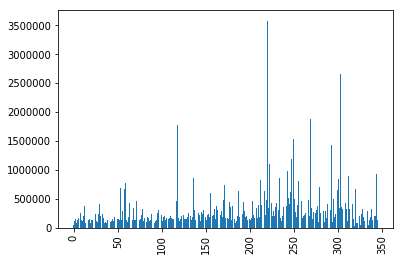

In [17]:
# Graph Data
#plt.bar(np.arange(0,len(df),1),df["Views"], tick_label = df["Date"])
plt.bar(np.arange(0,len(df),1),df["Views"])
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = [15,6]